# Analysis of varying trimming thresholds of microbial communities of known composition

Script for the analysis and figure generation for 515F/926R 16S and 18S mock communities

In [1]:
#Import libraries in python3 kernel
import pandas as pd
import seaborn as sns
import glob
import os
import sys
from pathlib import Path
#!conda install --yes --prefix {sys.prefix} boto
import boto
import shutil
#!conda install --yes --prefix {sys.prefix} tqdm
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import numpy as np
import skbio
#import fastcluster #this package makes skbio run faster clustermaps but can be tricky with missing values from pairwise comparisons
from functools import reduce
#!conda install --yes --prefix {sys.prefix} biopython
from Bio import SeqIO
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.SeqUtils import GC
from biom import load_table
from biom.table import Table
from collections import defaultdict
from collections import Counter
import statistics
import itertools as it
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
from qiime2 import Artifact
import tempfile
import zipfile
import yaml
#!conda install --yes --prefix {sys.prefix} -c etetoolkit ete3 
#!conda install -c bioconda seqkit
#pip install ete3
#conda install -c anaconda pyqt
#from ete3 import Tree, TreeStyle
%matplotlib inline

#Import libraries
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

## Load functions

__consolidate_tables__ creates a dataframe of all the merged generated feature tables and the parameters used in the pipeline to generate them

In [4]:
# Special thanks to Alex Manuele https://github.com/alexmanuele
def consolidate_tables(community):
    if community == "16S":
        comm_id, comm = '16S', '02-PROKs'
        table_list = glob.glob('{0}/*/03-DADA2d/table.qza'.format(comm+'/intermediate_files/all_trims/'))
        print("Found all 16S tables")
    if community == "18S":
        comm_id, comm = '18S','02-EUKs'
        table_list = glob.glob('{0}/*/08-DADA2/table.qza'.format(comm+'/intermediate_files/all_trims/'))
        print("Found all tables")

    dataframes = []  
    for table_path in table_list:
        with tempfile.TemporaryDirectory() as tempdir:
            #load table, dump contents to tempdir
            table = Artifact.load(table_path)
            #Make sure the tables are all FeatureFrequency type
            assert str(table.type) == 'FeatureTable[Frequency]', "{0}: Expected FeatureTable[Frequency], got {1}".format(table_path, table.type)
            Artifact.extract(table_path, tempdir)
            #get the provenance form the tempdir and format it for DF
            prov = '{0}/{1}/provenance/'.format(tempdir, table.uuid)
            action = yaml.load(open("{0}action/action.yaml".format(prov), 'r'), Loader=yaml.BaseLoader)
            paramlist = action['action']['parameters']
            paramlist.append({'table_uuid': "{}".format(table.uuid)})
            paramdict = {}
            for record in paramlist:
                paramdict.update(record)

            # Get the data into a dataframe
              #Biom data
            df = table.view(pd.DataFrame).unstack().reset_index()
            df.columns = ['feature_id', 'sample_name', 'feature_frequency']
            df['table_uuid'] = ["{}".format(table.uuid)] * df.shape[0]
              #param data
            pdf = pd.DataFrame.from_records([paramdict])
              #merge params into main df
            df = df.merge(pdf, on='table_uuid')


            #I like having these columns as the last three. Makes it more readable
            cols = df.columns.tolist()
            reorder = ['sample_name', 'feature_id', 'feature_frequency']
            for val in reorder:
                cols.append(cols.pop(cols.index(val)))
            df = df[cols]
            df['table_path'] = [table_path] * df.shape[0]
            dataframes.append(df)

    #Stick all the dataframes together
    #outputfile="merged_all_tables.tsv"
    df = pd.concat(dataframes)
    #df.to_csv(comm+'/merged_all_tables.tsv', sep='\t', index=False)
    print("Successfully saved all tables.")
    return df, comm, comm_id

__merge_metadata__ adds the metadata to the merged feature tables

In [5]:
def merge_metadata():
    #df = pd.read_csv('02-PROKs/'+'/merged_all_tables.tsv', sep='\t')

    tables = df[['sample_name', 'feature_id', 'feature_frequency']].copy()
    tables.rename(columns={'sample_name':'file'}, inplace=True)
    manifest = pd.read_csv('MANIFEST.tsv', sep='\t')
    manifest['file'] = [s.split('SPOT_USC_2/')[1] for s in manifest['absolute-filepath']]
    manifest['file'] = [s.split('.R')[0] for s in manifest['file']]
    manifest = manifest.drop(columns = ['absolute-filepath', 'direction'])
    manifest.drop_duplicates()
    merged = pd.merge(tables,manifest, on='file')
    merged = merged.drop(columns = ['file'])
    merged = merged.drop_duplicates() 
    print('Set up manifest ...')
    
    metadata = pd.read_csv('METADATA.tsv', sep='\t')
    merged = pd.merge(merged,metadata, on='sample-id')
    merged = merged.replace({'V2': '16S'}, regex=True)
    print('Set up metadata ...')
    
    #merged.to_csv(comm+'/merged_asvs_metadata.tsv', sep = '\t')
    print('Saved merged_asvs_metadata.tsv')
    
    return merged

__rename_move_taxonomy__ rename taxonomy

In [6]:
def rename_move_all_taxonomies(comm):
    dr = comm+'/intermediate_files/all_trims'
    if not os.path.isdir(dr):
        for root, dirs, files in os.walk(dr): #rename all taxonomy.tsv by their trimlengths
            for file in files:
                if file == "taxonomy.tsv":
                    spl = root.split("/"); newname = spl[-6]; sup = ("/").join(spl[:-6])
                    shutil.copy(root+"/"+file, sup+"/"+newname+".tsv");# shutil.rmtree(root)
        files = glob.glob('{0}F*R*.tsv'.format(dr))
        os.mkdir(dr)
        for file in files:
            shutil.move(file, dr) #puts all tsvs in new directory with correct names
    print('Renamed all taxonomies.')

__pick_metadata__ extracts the features according to the given metadata parameters

In [7]:
def pick_metadata(comm, comm_id, composition, runnumber, R='all', F='all'):
#make df of features/composition+run+comm

    composition = composition
    runnumber = runnumber
    R = R
    F = F

    files = glob.glob('{0}*.tsv'.format(comm+'/intermediate_files/all_taxonomies/'))
    taxos = []
#    if not os.path.exists(path+composition):
#        os.mkdir(path+composition)
    for filename in files:
        tax = pd.read_csv(filename, sep='\t')
        tax['table_id'] = str(filename.split('/')[-1])
        tax["table_id"] = tax["table_id"].str.replace(".tsv", "")
        tax['Forward_trim'], tax['Reverse_trim'] = tax['table_id'].str.split('R', 1).str
        tax['Forward_trim'] = tax['Forward_trim'].map(lambda x: x.lstrip('F'))
        tax["Forward_trim"] = pd.to_numeric(tax["Forward_trim"])
        tax["Reverse_trim"] = pd.to_numeric(tax["Reverse_trim"])
        taxos.append(tax)
    print('Appended all taxonomies to taxos')
    taxos = pd.concat(taxos)
    taxos = taxos.rename(columns={"Feature ID": "feature_id"}, errors="raise")
    #taxos.to_csv(comm+'/taxos.tsv', sep = '\t')
    separated = merged.merge(taxos, how='left', on='feature_id')
    separated = separated.drop_duplicates()
    separated = separated[separated["community"] == comm_id]
    separated = separated[separated["composition"] == composition]
    separated['run-number']= separated['run-number'].astype(str)
    separated = separated[separated["run-number"] == runnumber]
    separated['total'] = separated.groupby(['table_id','sample-id'])['feature_frequency'].transform('sum')
    separated['ratio'] = separated['feature_frequency']/(separated['total'])
    separated_taxonomies = separated.copy()
    #make a dictionary with keys for id-ing the taxon belonging to this sub-community
    separated_dic = pd.Series(separated.Taxon.values,separated.feature_id.values).to_dict()
    print('Saved separated by metadata dataframe.')
    
    return composition, runnumber, R, F, separated, files

__rename_taxonomies__ extracts zipped classification files from qiime2, renames them by the trimming length used, and moves them to a new folder

In [8]:
def pick_taxonomies(comm, comm_id,  composition, runnumber, files):
#generate folder of split taxonomies by runnumber and composition
    # Directory
    directory = composition+runnumber
    # Parent Directory path
    parent_dir = comm+'/intermediate_files/all_taxonomies'
    # Path
    path = os.path.join(parent_dir, directory)
    # Create the directory
    # 'GeeksForGeeks' in
    # '/home / User / Documents'
    if not os.path.isdir(parent_dir+'/'+directory): 
        os.mkdir(path)
        for filename in files:
            taxonomy = pd.read_csv(filename, sep='\t')
            taxonomy = taxonomy.rename(columns={"Feature ID": "feature_id"}, errors="raise")
            newz = taxonomy.merge(merged, how='left', on='feature_id')
            #new = newz.drop(['sample-id'], axis=1)
            new = newz.drop_duplicates()
            new = new[new["community"] == comm_id]
            new = new[new["composition"] == composition]
            new['run-number']= new['run-number'].astype(str)
            new = new[new["run-number"] == runnumber]
            new = new[new.feature_frequency != 0]
            new = new.rename(columns={"feature_id":"Feature ID"}, errors="raise")
            new = new[['Feature ID', 'Taxon', 'Confidence']].copy()
            new = new.drop_duplicates()
            new = new.set_index('Feature ID')
            d = 'all_taxonomies/'
            if new.empty:
                print('DataFrame from '+ filename +' is empty!')
            else:
                new.to_csv(filename.split(d)[0]+d+composition+runnumber+'/'+runnumber+filename.split(d)[1], sep = '\t')
           
            print('Split taxonomies')
    else:
        print("Taxonomies already split")
    
    return

__make_fasta__ extracts sequences from zipped qiime2 files, and makes new fasta file for the features from the given metadata parameters

In [8]:
def make_fasta(comm, R, F, composition, runnumber):
    
    fastaoutfilename = comm+'/intermediate_files/all_seqs/allfasta.fasta'
    
    if not os.path.isfile(fastaoutfilename):
        os.mkdir(comm+'/intermediate_files/all_seqs')
        # Get list of all .qza
        repseqs = glob.glob('{0}/*/*/representative_sequences.qza'.format(comm+'/intermediate_files/all_trims'), recursive=True)
        #for i in tqdm
        for repseq in repseqs:
            with zipfile.ZipFile(repseq, 'r') as zipObj:
                # Get a list of all archived file names from the zip
                listOfFileNames = zipObj.namelist()
                # Iterate over the file names
                for fileName in listOfFileNames:
                    # Check filename endswith fasta
                    if fileName.endswith('.fasta'):
                        # Extract a single file from zip
                        zipObj.extract(fileName, 'temp_fasta')
                        
    
        with open(fastaoutfilename, 'wb') as outfile:
            for filename in glob.glob('temp_fasta/*/*/*.fasta'):
                if filename == fastaoutfilename:
                    # don't want to copy the output into the output
                    continue
                with open(filename, 'rb') as readfile:
                    shutil.copyfileobj(readfile, outfile)
        shutil.rmtree('temp_fasta', ignore_errors=False, onerror=None)
    

    if R!='all':
        rallfs = separated[separated.Reverse_trim == R]
        separated_dic = pd.Series(rallfs.Taxon.values,rallfs.feature_id.values).to_dict()
    else:
        separated_dic = pd.Series(separated.Taxon.values, separated.feature_id.values).to_dict()
    if F!='all':
        fallrs = separated[separated.Forward_trim == F]
        separated_dic = pd.Series(fallrs.Taxon.values,fallrs.feature_id.values).to_dict()
    else:
        separated_dic = pd.Series(separated.Taxon.values, separated.feature_id.values).to_dict()

    fa = SeqIO.parse(comm+'/intermediate_files/all_seqs/allfasta.fasta',
                 "fasta")
    seqs_i_want = [] #we'll put the good sequences here
    for record in fa: #a SeqRecord has the accession as record.id, usually.
        if record.id in separated_dic.keys(): #This is how you check if the accession is in the values of the dict
            seqs_i_want.append(record)
    #Now we can write the list of records to a fasta file. This will take care of the formatting etc
    with open(comm+'/intermediate_files/all_seqs/R'+R+'F'+F+runnumber+composition+'.fasta', "w") as f:
        SeqIO.write(seqs_i_want, f, "fasta")
        
    
    
    return print('Saved selected sequences as '+comm+'/intermediate_files/all_seqs/R'+R+'F'+F+runnumber+composition+'.fasta')

__make_phylo_tree__ runs mafft and FastTree to align and build a sequence tree for the sequences from all the trimming length combinations

In [9]:
def make_phylo_tree(separated):
    tax_key = separated[['Taxon', 'feature_id']].copy() #extract columns
    tax_key['key'] = [s.split('; ')[-2:] for s in tax_key['Taxon']] #extract only the last two tax ranks for visualization
    tax_key['key'] = tax_key['key'].apply(lambda x: '_'.join(map(str, x))) #convert list of last two ranks to string
    tax_keys = tax_key.copy()
    tax_keys_dic = pd.Series(tax_keys.key.values,tax_keys.feature_id.values).to_dict() #make into dictionary
    
    with open(comm+'/intermediate_files/all_seqs/R'+R+'F'+F+runnumber+composition+'.fasta') as original, open(comm+'/intermediate_files/all_seqs/R'+R+'F'+F+runnumber+composition+'_taxoids.fasta', 'w') as corrected:
        for seq_record in SeqIO.parse(original, 'fasta'):
            if seq_record.id in tax_keys_dic:
                seq_record.id = seq_record.description = tax_keys_dic[seq_record.id]
            SeqIO.write(seq_record, corrected, 'fasta')
            
    ! seqkit rmdup -n < $comm'/intermediate_files/all_seqs/R'$R'F'$F$runnumber$composition'_taxoids.fasta' > out.fa
    
    ! wc -l out.fa
    
    # Read in the file
    with open('out.fa', 'r') as file :
        filedata = file.read()

    # Replace the target strings because misinterpreted by FastTree
    filedata = filedata.replace('(', '[')
    filedata = filedata.replace(')', ']')

    # Write the file out again
    with open('out.fa', 'w') as file:
        file.write(filedata)
    
    ! ~/mafft-mac/mafft.bat out.fa > aligneddedup.fasta
    
    ! ~/FastTree -gtr -nt < aligneddedup.fasta > tree_18stg.nwk

__make_tbd_hm__ makes a heatmap showing the taxonomic beta diversity of each trim length combination against the expected community. TBD is a dissimilarity index based on taxonomic trees between two samples where 1 is completely different, and 0 is the completely the same.

In [10]:
def make_tbd_hm(comm, composition, runnumber, level=7):
    
    if not os.path.isdir('Bacaros_Beta'):
        ! git clone https://github.com/alexmanuele/Bacaros_Beta.git
        print("Bacaros Beta was cloned.")
    else:
        print("Bacaros Beta is already cloned.")
    
    #Move the expected community to the taxonomies folder for comparison
    dest_dir = comm+'/intermediate_files/all_taxonomies/'+composition+runnumber
    
    for file in glob.glob('in-silico-mocks/'+comm+'/'+composition+r'/*/data/taxonomy.tsv'):
        print(file+' was moved.')
        shutil.copy(file, os.path.join(dest_dir, 'expected.tsv'))
        
    tax_list = glob.glob('{0}/*.tsv'.format(comm+'/intermediate_files/all_taxonomies/'+composition+runnumber))
    textfile = open("tax_comp.txt", "w")
    for element in tax_list:
        textfile.write(element + "\n")
    textfile.close()
    print("Saved all taxonomies list as tax_comp.txt")

    if not os.path.isdir(dest_dir+'/TBD1'):
        for i in range(1, 8):
            output_dir = 'TBD'+str(i)
            os.mkdir(output_dir)
            ! python Bacaros_Beta/run_beta.py --input tax_comp.txt --metric t --l $i --output $output_dir
            shutil.move(output_dir, dest_dir)
    else:
        print("BTD Already ran")
        
    bacaros_dm = pd.read_csv(dest_dir+'/TBD'+str(level)+'/tax_comp.csv')
    bacaros_dm = bacaros_dm.set_index('Unnamed: 0')
    #bacaros_dm = 1  - bacaros_dm
    #bacaros_dm is a distance matrix of table X table
    #my_pcoa = skbio.stats.ordination.pcoa(bacaros_dm.values)
    #plt.scatter(my_pcoa.samples['PC1'],  my_pcoa.samples['PC2'])
    against_exp = bacaros_dm[['expected']].copy()
    against_exp = against_exp.reset_index().rename(columns={against_exp.index.name:'sample_name'})
    against_exp.drop(against_exp.index[against_exp['sample_name'] == 'expected'], inplace=True)
    against_exp['Forward_trim'] = [s.split('R')[0] for s in against_exp['sample_name']]
    against_exp['Forward_trim'] = [s.split(runnumber+'F')[1] for s in against_exp['Forward_trim']]
    against_exp['Reverse_trim'] = [s.split('R')[1] for s in against_exp['sample_name']]
    against_exp["Forward_trim"] = pd.to_numeric(against_exp["Forward_trim"])
    against_exp["Reverse_trim"] = pd.to_numeric(against_exp["Reverse_trim"])
    against_exp["Forward_trim"].replace({0: 280}, inplace=True)
    against_exp["Reverse_trim"].replace({0: 290}, inplace=True)
    tohm = against_exp.pivot("Forward_trim", "Reverse_trim", "expected")
    tohm.rename({280: 'full'}, axis=0, inplace=True)
    tohm.rename({290: 'full'}, axis=1, inplace=True)
    ax = sns.heatmap(tohm, cmap=sns.color_palette("coolwarm", as_cmap=True), vmin=0, vmax=1)
    ax.invert_yaxis()
    #plt.figure(figsize=(12,12))
    fig = ax.get_figure()
    fig.savefig(f'outputs/{comm_id}{composition}{runnumber}{level}bacaros.png',
                bbox_inches = "tight")
    
    # get max and min values
    #print('The min value is {0} and the max value is {1}'.format(df.at[df.stack().index[np.argmin(df.values)]], 
    #                                                             minv = df.at[df.stack().index[np.argmax(df.values)]]))

    return tohm, dest_dir

In [37]:
#calculate the min length of reads that lead to a result and make a presence absence

__r2_plot__ makes a linear regression of the observed relative abundances of each combination of trim lengths against the expected, and plots each coefficient of determination in a heatmap

In [38]:
## to import the expected taxonomies and transofrm to ratios
def expected_df(comm, composition):
    expected_silva = pd.read_csv('in-silico-mocks/'+comm+'/expected.tsv', sep='\t')
    expected_silva_selected = expected_silva.loc[~((expected_silva[composition+'_percent_expected'] == 0))]
    expected_silva_selected[composition+'_ratio_expected'] = expected_silva_selected[composition+'_percent_expected']/(expected_silva_selected[composition+'_percent_expected'].sum())
    ax = sns.barplot(x=composition+"_ratio_expected", y="Clone_name", data=expected_silva_selected, saturation=.5)
    ax.set(xlabel='Relative abundance', ylabel='Group')
    #ax.bar_label(ax.containers[0])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.figure.savefig(comm+composition+'_expected.png', bbox_inches='tight')
    fig = ax.get_figure()
    fig.savefig('outputs/'+comm+composition+'_expected.png', bbox_inches = "tight")

        
    #make r2 fig
    expobs_comp = separated.merge(expected_silva_selected, on='Taxon', how='outer')
    expobs_comp = expobs_comp.fillna(0)
    expobs_comp["Clone_name"].replace({0: "False positive"}, inplace=True)
    grouped = expobs_comp.groupby(['Forward_trim', 'Reverse_trim'])
    test = (grouped.apply(lambda x: pd.Series(stats.linregress(x[composition+'_ratio_expected'], x['ratio'])))
               .rename(columns={
                        0: 'slope',
                        1: 'intercept',
                        2: 'rvalue',
                        3: 'pvalue',
                        4: 'stderr'}))
    test['r2'] = test['rvalue']**2
    testcopy = test.reset_index()
    testcopy["Forward_trim"].replace({0: 300}, inplace=True) #0 trim length translates to no trimming, so max read length
    testcopy["Reverse_trim"].replace({0: 300}, inplace=True)
    tohm = testcopy.pivot("Forward_trim", "Reverse_trim", "r2")
    tohm.fillna(0)
    ax = sns.heatmap(tohm,cmap=("coolwarm"), vmin=0, vmax=1)
    ax.invert_yaxis()
    #plt.figure(figsize=(12,12))
    ax.set(xlabel='Reverse trim length', ylabel='Forward trim length')
    fig = ax.get_figure()
    fig.savefig('outputs/'+comm_id+composition+runnumber+'_r2.png', bbox_inches = "tight")


    return expected_silva_selected, testcopy, expobs_comp

__make_fold_change_plots__ makes a heatmap of the log2 fold change for all expected groups

In [54]:
def make_fold_change_plots(expobs_comp, composition):
    #add the keys to expobs for matching with the tree tip labels
    expobs_comp['key'] = [s.split('; ')[-2:] for s in expobs_comp['Taxon']] #extract only the last two tax ranks for visualization
    expobs_comp['key'] = expobs_comp['key'].apply(lambda x: '_'.join(map(str, x))) #convert list of last two ranks to string
    expobs_comp['ratio'] = expobs_comp['ratio'].fillna(0)
    
    separcopy = expobs_comp.copy()
    separcopy['Phylum'] = separcopy['Taxon'].str.split('; ').str[1]
    separcopy['Phylum'] = separcopy['Phylum'].str.split('p__').str[1]
    
    separcopy[[composition+'_ratio_expected']] = separcopy[[composition+'_ratio_expected']].apply(pd.to_numeric)
    separcopy['Type'] = np.where(
        separcopy[composition+'_ratio_expected'] > 0, 'TP', 'FP')
    
    separcopy['Size'] = separcopy['ratio'].copy()
    separcopy = separcopy.rename(columns={"key": "ID"})
    
    clonenames = separcopy.Clone_name.unique().tolist()
    clonenames_id = [clonename.replace(' ', '_') for clonename in clonenames]
    clonenames_id = [clonename.replace('(', '') for clonename in clonenames_id]
    clonenames_id = [clonename.replace(')', '') for clonename in clonenames_id]
    
    for clonename in clonenames:
        clone = separcopy.loc[separcopy['Clone_name'] == clonename]
        clone = clone[['Forward_trim', 'Reverse_trim', composition+'_ratio_expected', 'ratio']]
        clone = clone.groupby(['Forward_trim', 'Reverse_trim']).mean()
        clone = clone.reset_index()
        clone['fold_change'] = clone['ratio']/clone[composition+'_ratio_expected']
        clone['log2_fold_change'] = np.log2(clone['fold_change'])
        forhm = pd.pivot_table(clone, values= 'log2_fold_change', index='Forward_trim', columns='Reverse_trim')
        forhm = forhm.fillna(0)
        ax = sns.heatmap(forhm, cmap=sns.color_palette("coolwarm", as_cmap=True))#, cbar=False)
        ax.invert_yaxis()
        fig = ax.get_figure()
        fig.savefig(f'outputs/{comm_id}{composition}{runnumber}{clonename}.png',
                    bbox_inches = "tight")
        plt.clf()


__even_comm_expected__ makes a catplot for the even 16S and 18S community to compare each expected clone and false positives against it's observed ratio for each trim length combination

In [12]:
def even_comm_expected():
    expobs_comp_copy = expobs_comp[['table_id', 'ratio', 'Clone_name', 'sample-id', 'Forward_trim', 'Reverse_trim']].copy()
    expobs_comp_copy['sums'] = expobs_comp_copy.groupby(['table_id', 'sample-id', 'Clone_name'])['ratio'].transform(lambda x: x.sum())
    expobs_comp_copy["Forward_trim"].replace({0: 280}, inplace=True)
    expobs_comp_copy["Reverse_trim"].replace({0: 290}, inplace=True)
    
    g = sns.catplot(x="Clone_name", y="sums", hue="Forward_trim", kind="point", data=expobs_comp_copy, xticklabels=1, scale = 0.5#marker size 
                , palette='gray_r', size = 4, aspect = 2)
    #g.set(ylim=(0, 1))
    g.set(xlabel='Clone name', ylabel='Proportion', yticks=np.arange(0,1.02,0.2))
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=85)
    #g.tight_layout()
    g.savefig(f'outputs/{comm_id}{composition}{runnumber}obsratioline_angle85.png',
                bbox_inches = "tight")

__ttst__ runs a t-test for each expected clone for a given trim length combination

In [75]:
#run 1 sample t test
#takes trimcombination in format F40R40
def ttst(trimcombination):
    compr_obs_exp = expected_silva_selected.merge(separated, how='outer', on='Taxon')
    compr_obs_exp = compr_obs_exp.rename(columns={'sample-id': 'Replicate'})
    compr_obs_exp=compr_obs_exp.fillna(0)
    compr_obs_exp["Clone_name"].replace({0: "False positive"}, inplace=True)
    df_with_groups = compr_obs_exp[compr_obs_exp.table_id == trimcombination]
    
    #add if empty, return message saying this trim length is bad!
    
    
    means = df_with_groups.groupby('Clone_name').mean()
    newsi=means[[composition+'_ratio_expected', 'ratio']].copy()
    newsi.sort_values(composition+'_ratio_expected', ascending = False)
    newsi['Difference'] = newsi[composition+'_ratio_expected'] / newsi['ratio']
    newsi
    
    # generate a boxplot to see the data distribution by treatments. Using boxplot, we can easily detect the differences between different treatments
    ax = sns.boxplot(x='ratio', y='Clone_name', data=df_with_groups).set(
    xlabel='Relative abundance', 
    ylabel='Group'
    )
    plt.show()

    
    groups = df_with_groups['Clone_name'].unique()
    results = []
    for group in groups:    
        arr = df_with_groups[(df_with_groups['Clone_name'] == group)]['ratio'].values  #Filter the dataframe. 
        results.append({'Clone_name': group,
                        'ratios': arr}) #Make a single "record" containing the table id, replicate, and ratio array.
        r_gr = pd.DataFrame.from_records(results)
    
    y = expected_silva_selected[composition+'_ratio_expected']
    for i in range(len(y[0:-1])):
        xi = r_gr.iloc[i]['ratios']
        yi = y[i]
        print(r_gr.iloc[i]['Clone_name'])
        print(stats.ttest_1samp(xi, yi))
        #but there are outliers
    return (r_gr, newsi)

In [56]:
def thresholds():
    dic = {
        "Domain": f'{dest_dir}/TBD1/tax_comp.csv',
        "Phylum": f'{dest_dir}/TBD2/tax_comp.csv',
        "Class": f'{dest_dir}/TBD3/tax_comp.csv',
        "Order": f'{dest_dir}/TBD4/tax_comp.csv',
        "Family": f'{dest_dir}/TBD5/tax_comp.csv',
        "Genus": f'{dest_dir}/TBD6/tax_comp.csv',
        "Species": f'{dest_dir}/TBD7/tax_comp.csv'
    }
    thresholds = [1.0, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.30, 0.25, 0.20, 0.15, 0.10, 0.05, 0]
    df = pd.DataFrame(columns=['Rank', *thresholds]) #* unpack the list and adds to list, **is for unpacking dictionaries
    #eg. d3 = {**d1, **d2} or l3 = [*l1, *l2]
    for key in dic.keys():
        #tohm, dest_dir = make_tbd_hm(comm, composition, runnumber, level='6')
        #tohm, bacaros_dm, agexp = make_tbd_hm(dic[key], expected_file) #input the value of each key from the dictionary
        tohm = pd.read_csv(dic[key], index_col=0)
        row ={'Rank': key} #make an empty dictionary
        for thresh in thresholds:
            pp = ((tohm[tohm > thresh].count().sum())/tohm.size)*100
            row[thresh] = pp
        df = df.append(row, ignore_index=True)
    
    newdf = df.set_index(['Rank'])
    newdf['Rank'] = newdf.index
    melted = newdf.melt('Rank', var_name='Thresholds', value_name='TD')
    melted[["Thresholds", "TD"]]=melted[["Thresholds", "TD"]].apply(pd.to_numeric)
    
    sns.set_context('paper')
    fig = plt.figure(figsize=(5,5))
    p = sns.lineplot(data=melted, x="Thresholds", y="TD", hue='Rank', legend = True)
    p.set(ylim=(0, 100))
    p.set(xlim=(0,1))
    p.set_xlabel("\u03B2 diversity") #, fontsize = 10)
    p.set_ylabel("Percentage of tables",)# fontsize = 10)
    #p.invert_xaxis()
    ax = p.get_figure()
    ax.savefig(f'outputs/thresholds{comm_id}_{composition}_{runnumber}_with_legend.png', format='png', dpi=600, bbox_inches="tight")
    return df

__get_fig_per_group__ makes a heatmap of the observed against expected relative abundances for given group names and colors ratios above the expected in blues, and below the expected in reds.

In [186]:
def get_fig_per_group(groupname, expectedratio, duplicate='mean'):
    neoceratium = separated[separated['Taxon'].str.contains(groupname)]
    neoceratium = neoceratium[neoceratium.feature_frequency !=0]
    neoceratium.rename(columns = {'sample-id':'sample_id'}, inplace=True)
    if duplicate!='mean':
        neoceratiumR1 = neoceratium[neoceratium.sample_id == 'R46-'+comm_id+'-'+duplicate]
    else:
        neoceratiumR1 = neoceratium.groupby(['Forward_trim','Reverse_trim'])[['ratio']].mean()
        neoceratiumR1 = neoceratiumR1.reset_index()
    neoceratiumR1["Forward_trim"] = pd.to_numeric(neoceratiumR1["Forward_trim"])
    neoceratiumR1["Reverse_trim"] = pd.to_numeric(neoceratiumR1["Reverse_trim"])
    neoceratiumR1["Forward_trim"].replace({0: 280}, inplace=True)
    neoceratiumR1["Reverse_trim"].replace({0: 290}, inplace=True)
    neoceratiumR1merged = neoceratiumR1.groupby(['Forward_trim','Reverse_trim'])[['ratio']].mean()
    neoceratiumR1merged = neoceratiumR1merged.reset_index()
    tohm = neoceratiumR1merged.pivot("Forward_trim", "Reverse_trim", "ratio")
    tohm.rename({280: 'full'}, axis=0, inplace=True)
    tohm.rename({290: 'full'}, axis=1, inplace=True)
    ax = sns.heatmap(tohm, cmap="Oranges_r")#, mask= (tohm < (expectedratio-(0.0005*expectedratio))) & (tohm > (expectedratio+(0.0005*expectedratio)))) #cmap=sns.color_palette("hls", 90)
    ax = sns.heatmap(tohm, mask=tohm <= expectedratio, cmap=sns.color_palette("GnBu", 5)) #square=True, annot=False, vmin=0, vmax=1, cbar=False, ax=ax)
    #ax = sns.heatmap(tohm, mask=tohm >= expectedratio, cmap=sns.color_palette("Oranges_r", 5)) #square=True, annot=False, vmin=0, vmax=1, cbar=False, ax=ax)
    ax.invert_yaxis()
    plt.figure(figsize=(12,12))
    ax.set(xlabel='Reverse trim length', ylabel='Forward trim length')
    fig = ax.get_figure()
    fig.savefig('ratio'+groupname+'.png', bbox_inches = "tight")
    return neoceratiumR1merged

__ttst__ runs one sample t tests between each taxonomic groups observed against expected relative abundances, and plots the results in a boxplot for a single trimming combination

In [387]:
#run 1 sample t test
#takes trimcombination in format F40R40
def ttst(trimcombination):
    compr_obs_exp = expstagg.merge(separated, how='outer', on='Taxon')
    compr_obs_exp = compr_obs_exp.rename(columns={'sample-id': 'Replicate'})
    compr_obs_exp=compr_obs_exp.fillna(0)
    compr_obs_exp["group"].replace({0: "False positive"}, inplace=True)
    df_with_groups = compr_obs_exp[compr_obs_exp.table_id == trimcombination]
    
    
    means = df_with_groups.groupby('group').mean()
    newsi=means[['expected_ratio', 'ratio']].copy()
    newsi.sort_values('expected_ratio', ascending = False)
    newsi['Difference'] = newsi['expected_ratio'] / newsi['ratio']
    newsi
    
    # generate a boxplot to see the data distribution by treatments. Using boxplot, we can easily detect the differences between different treatments
    ax = sns.boxplot(x='ratio', y='group', data=df_with_groups).set(
    xlabel='Relative abundance', 
    ylabel='Group'
    )
    #ax.tick_params(axis='x', labelrotation=90)
    plt.show()
    
    results = []
    for group in groups:    
        arr = df_with_groups[(df_with_groups['group'] == group)]['ratio'].values  #Filter the dataframe. 
        results.append({'group': group,
                        'ratios': arr}) #Make a single "record" containing the table id, replicate, and ratio array.
        r_gr = pd.DataFrame.from_records(results)
    
    y = expstagg['expected_ratio']
    for i in range(len(y[0:-1])):
        xi = r_gr.iloc[i]['ratios']
        yi = y[i]
        print(r_gr.iloc[i]['group'])
        print(stats.ttest_1samp(xi, yi))
        #but there are outliers
    return (r_gr, newsi)

## Run analyses and make figures

In [410]:
def get_figures(community, composition, runnumber, R='all', F='all',level=7):
    
    df, comm, comm_id = consolidate_tables(community) #concat all feature tables and their pipeline parameters
    merged = merge_metadata() #add the metadata
    composition, runnumber, R, F, separated_taxonomies, separated_dic, files, tax, separated, taxos = pick_metadata(composition, runnumber)
    pick_taxonomies() #rename the taxonomy tsv files for taxonomic beta diversity
    make_fasta() #extract the sequences
    make_tbd_hm(level=7) #make TBD heatmap
    ## add function to find best trim length ranges (white box)
    ## add table of thresholds + line plot
    r2_plot()
    ##run t tests for best TBD and best r2, make boxplot
    #get_fig_per_group()
    ## get sequence comparison
    ## get files for import to evolview --tree, abundance table, branch coloring and expected ratios
    
    return

Found all tables
Success.
Set up manifest ...
Set up metadata ...
Saved merged_asvs_metadata.tsv
Appended all taxonomies to taxos


/Users/Diana/miniconda3/envs/qiime2-2020.111/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Columnar iteration over characters will be deprecated in future releases.


Taxonomies already split
Saved selected sequences as 02-PROKs/all_seqs/RallFall46Staggered.fasta
Bacaros Beta is already cloned.
in-silico-mocks/02-PROKs/Staggered/7fee7113-8e8a-459b-ae32-6d8381294d5c/data/taxonomy.tsv was moved.
Saved all taxonomies list as tax_comp.txt
BTD Already ran


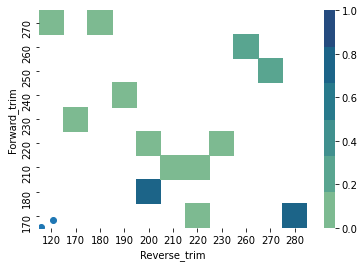

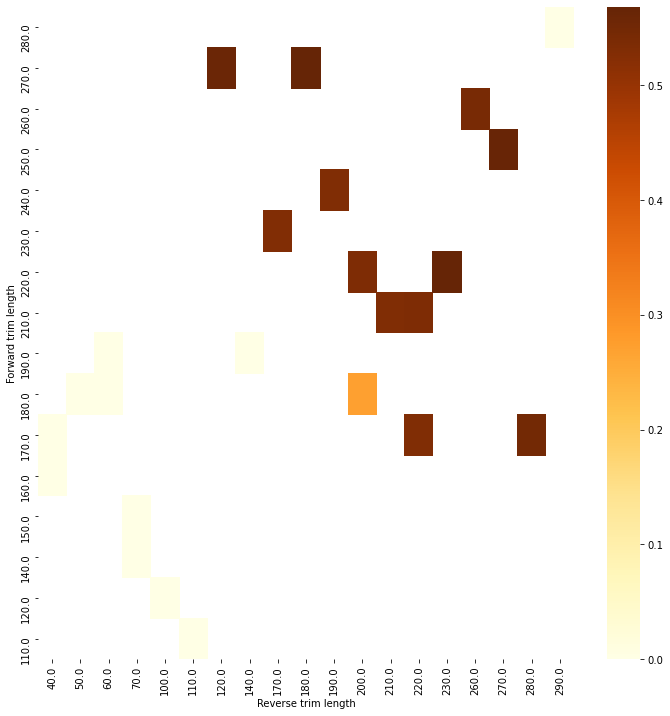

<Figure size 864x864 with 0 Axes>

In [411]:
get_figures('18S', 'Staggered', '46')